## Imports

In [1]:
import os
os.chdir("../")
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap
#from modules.recon_adversarial_module import ReconAdversarialModule

In [3]:
class lca_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_768_mnist"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

class ae_params(object):
  def __init__(self):
    self.model_type = "ae"
    self.model_name = "ae_768_mnist"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

params_list = [ae_params(), lca_params()]
for params in params_list:
  params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+params.model_name)

In [4]:
analyzer_list = [ap.get_analyzer(params.model_type) for params in params_list]
for analyzer, params in zip(analyzer_list, params_list):
  analyzer.setup(params)
  analyzer.setup_model(analyzer.model_params)
  analyzer.load_analysis(save_info=params.save_info)
  analyzer.model_name = params.model_name

In [5]:
# load data
dataset_type = "train"
data = ds.get_data(analyzer_list[0].model_params)
data = analyzer_list[0].model.preprocess_dataset(data, analyzer.model_params)
data = analyzer_list[0].model.reshape_dataset(data, analyzer.model_params)
data_min = data[dataset_type].images.min()
data_max = data[dataset_type].images.max()
dataset_size = data[dataset_type].images.shape[0]
print("NUM DATA", dataset_size, 'DATA MIN', data_min, 'DATA MAX', data_max)

Preprocessing: Normalized train data with maximum
Preprocessing: Normalized test data with maximum
NUM DATA 60000 DATA MIN 0.0 DATA MAX 0.99999905


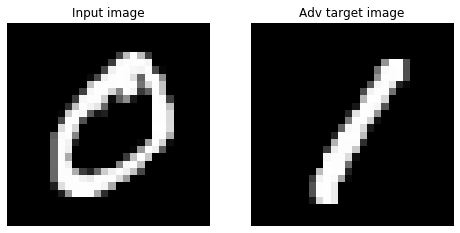

In [6]:
adv_inputs = np.stack([data[dataset_type].images[img_id,...]
  for img_id in range(dataset_size)
  if dp.one_hot_to_dense(data[dataset_type].labels[img_id][None,...]) == 0])
              
adv_targets = np.stack([data[dataset_type].images[img_id,...]
  for img_id in range(dataset_size)
  if dp.one_hot_to_dense(data[dataset_type].labels[img_id][None,...]) == 1])

if adv_inputs.shape[0] > adv_targets.shape[0]:
  adv_inputs = adv_inputs[:adv_targets.shape[0],...]
else:
  adv_targets = adv_targets[:adv_inputs.shape[0],...]

fig, axes = plt.subplots(1, 2, figsize=(8,4))
ax = pf.clear_axis(axes[0])
ax.imshow(adv_inputs[0].reshape(28,28), cmap="Greys_r")
ax.set_title("Input image")
ax = pf.clear_axis(axes[1])
ax.imshow(adv_targets[0].reshape(28,28), cmap="Greys_r")
ax.set_title("Adv target image")
plt.show()

In [7]:
adv_inputs = adv_inputs[0,...][None,...]
adv_targets = adv_targets[0,...][None,...]

In [61]:
#self.adv_loss =  input_pert_loss + self.recon_mult * adv_recon_loss

#AE
params_list[0].do_recon_adversaries = True
params_list[0].adversarial_num_steps = 1000
params_list[0].adversarial_attack_method = "carlini_targeted"
params_list[0].adversarial_step_size = 0.0#1e-2
params_list[0].adversarial_max_change = 0.6
params_list[0].adversarial_clip = True
params_list[0].adversarial_clip_range = [0.0, 0.1]
params_list[0].carlini_recon_mult = 2000
params_list[0].adversarial_save_int = 1

#LCA
params_list[1].do_recon_adversaries = True
params_list[1].adversarial_num_steps = 100
params_list[1].adversarial_attack_method = "carlini_targeted"
params_list[1].adversarial_step_size = 1e-5
params_list[1].adversarial_max_change = 0.2
params_list[1].adversarial_clip = False
params_list[1].adversarial_clip_range = [0.0, 1.0]
params_list[1].carlini_recon_mult = 10
params_list[1].adversarial_save_int = 1

In [62]:
for analyzer, params in zip(analyzer_list, params_list):
  analyzer.analysis_params.adversarial_num_steps = params.adversarial_num_steps
  analyzer.analysis_params.adversarial_attack_method = params.adversarial_attack_method
  analyzer.analysis_params.adversarial_step_size = params.adversarial_step_size
  analyzer.analysis_params.adversarial_max_change = params.adversarial_max_change
  analyzer.analysis_params.adversarial_clip = params.adversarial_clip
  analyzer.analysis_params.adversarial_clip_range = params.adversarial_clip_range
  analyzer.analysis_params.carlini_recon_mult = params.carlini_recon_mult
  analyzer.analysis_params.adversarial_save_int = params.adversarial_save_int
  
  analyzer.model.reset_graph()
  
  analyzer.setup_model(analyzer.model_params)
  
  #analyzer.model.add_step_counter_to_graph()
  #with tf.device(analyzer.model.params.device):
  #  with analyzer.model.graph.as_default():
  #    analyzer.input_node = analyzer.model.build_input_placeholder()
  #    with tf.variable_scope("placeholders") as scope:
  #      analyzer.use_adv_input = tf.placeholder(tf.bool, shape=(), name="use_adv_input")
  #    analyzer.recon_adv_module = ReconAdversarialModule(analyzer.input_node, analyzer.use_adv_input,
  #      params.adversarial_num_steps, params.adversarial_step_size,
  #      params.adversarial_max_change, params.adversarial_clip,
  #      params.adversarial_clip_range, params.adversarial_attack_method)
  #analyzer.model.build_graph_from_input(analyzer.recon_adv_module.adv_image)
  #with tf.device(analyzer.model.params.device):
  #  with analyzer.model.graph.as_default():
  #    analyzer.recon_adv_module.build_adversarial_ops(analyzer.model.reconstruction)
  #analyzer.model.full_model_load_ignore.extend(analyzer.recon_adv_module.ignore_load_var_list)
  #analyzer.model.load_schedule(analyzer.model.params.schedule)
  #analyzer.add_pre_init_ops_to_graph()
  #analyzer.model.add_optimizers_to_graph()
  #analyzer.model.add_initializer_to_graph()
  #analyzer.model.construct_savers()

In [63]:
"""
all_adversarial_images is a nested list [num_recon_mults][num_steps] and then an ndarray of shape (1, 784)
all_recons is a nested list [num_recon_mults][num_steps] and then an ndarray of shape (1, 784)
"""
for analyzer in analyzer_list:
  analyzer.steps, analyzer.all_adversarial_images, analyzer.all_recons, analyzer.distances = \
    analyzer.construct_recon_adversarial_stimulus(adv_inputs, adv_targets)

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/ae_768_mnist/checkpoints/ae_768_mnist_v0.0-500000
INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca_768_mnist/checkpoints/lca_768_mnist_v0.0-500000


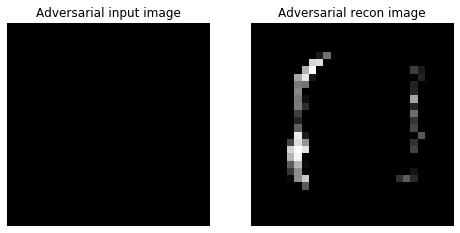

In [64]:
analyzer_idx = 0
batch_idx = 0
step_idx = -1
recon_idx = 0
fig, axes = plt.subplots(1, 2, figsize=(8,4))
ax = pf.clear_axis(axes[0])
ax.imshow(analyzer_list[analyzer_idx].all_adversarial_images[0][step_idx][batch_idx,...].reshape(28,28),
  cmap="Greys_r")
ax.set_title("Adversarial input image")
ax = pf.clear_axis(axes[1])
ax.imshow(analyzer_list[analyzer_idx].all_recons[0][step_idx][batch_idx,...].reshape(28,28),
  cmap="Greys_r")
ax.set_title("Adversarial recon image")
plt.show()

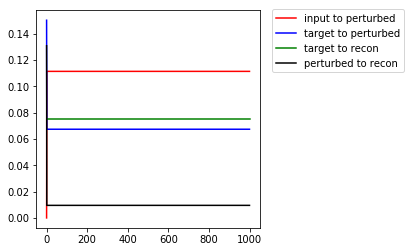

In [65]:
#These mses are in shape [num_recon_mults, num_iterations, num_batch]
fig, ax = plt.subplots(1, figsize=(4,4))
ax.plot(analyzer_list[analyzer_idx].steps,
  np.array(analyzer_list[analyzer_idx].distances["input_adv_mses"])[recon_idx, :, batch_idx],
  label='input to perturbed', color='r')

ax.plot(analyzer_list[analyzer_idx].steps,
  np.array(analyzer_list[analyzer_idx].distances["target_adv_mses"])[recon_idx, :, batch_idx],
  label='target to perturbed', color='b')

ax.plot(analyzer_list[analyzer_idx].steps,
  np.array(analyzer_list[analyzer_idx].distances["target_recon_mses"])[recon_idx, :, batch_idx],
  label='target to recon', color='g')

ax.plot(analyzer_list[analyzer_idx].steps,
  np.array(analyzer_list[analyzer_idx].distances["adv_recon_mses"])[recon_idx, :, batch_idx],
  label='perturbed to recon', color='k')

fig.legend(loc="upper right", bbox_to_anchor=(1.42, 0.86))
plt.show()

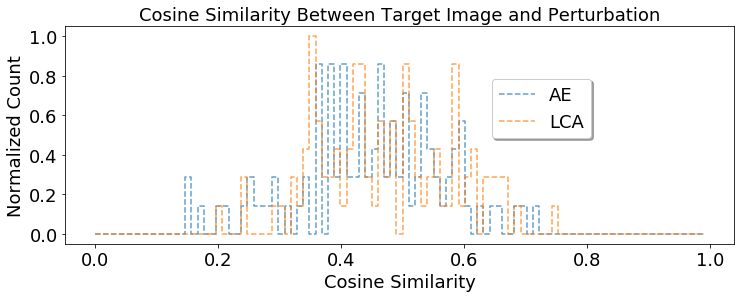

In [62]:
num_bins = 100
similarities = []
for analyzer in analyzer_list:
  similarities.append(analyzer.adversarial_target_adv_cos_similarities[0][-1])
min_dist = np.minimum(0.0, np.min(similarities))
max_dist = np.maximum(1.0, np.max(similarities))
bins = np.linspace(min_dist, max_dist, num_bins)
fontsize = 18
line_alpha = 0.7

fig, ax = plt.subplots(1, figsize=(12,4))
for analyzer_idx, analyzer in enumerate(analyzer_list):
  cos_similarity = similarities[analyzer_idx]
  analyzer.dist_hist, bin_edges = np.histogram(cos_similarity, bins=bins)
  bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
  bin_centers = bin_left + (bin_right - bin_left)/2
  
for analyzer_idx, analyzer in enumerate(analyzer_list):
  analyzer.dist_hist = analyzer.dist_hist / np.max([analyzer.dist_hist for analyzer in analyzer_list])
  ax.plot(bin_left, analyzer.dist_hist, alpha=line_alpha, linestyle="--", #color = 'k',
    drawstyle="steps-mid", label=analyzer.model_params.model_type.upper())
  
title = ("Cosine Similarity Between Target Image and Perturbation")
ax.set_title(title, fontsize=fontsize)
ax.set_xlabel("Cosine Similarity", fontsize=fontsize)
ax.set_ylabel("Normalized Count", fontsize=fontsize)
ax.tick_params("both", labelsize=fontsize)
ax.legend(fontsize=fontsize, fancybox=True, shadow=True, bbox_to_anchor=(0.8, 0.8))
plt.show()

for analyzer in analyzer_list:
  fig.savefig(analyzer.analysis_out_dir+"/vis/cosyne_similarity.png", transparent=True, bbox_inches="tight", pad_inches=0.01)

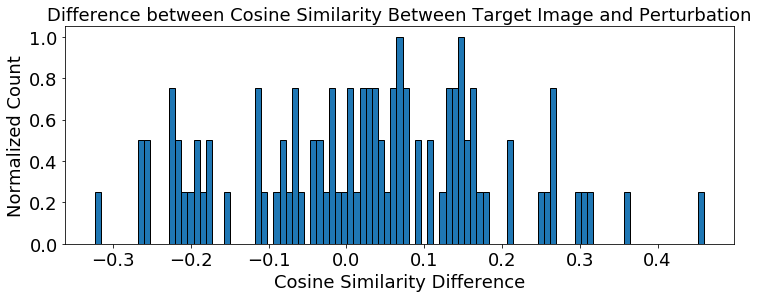

In [60]:
diff_list = similarities[1] - similarities[0]

bins = np.linspace(np.min(diff_list), np.max(diff_list), num_bins)
dist_hist, bin_edges = np.histogram(diff_list, bins=bins)
dist_hist = dist_hist / np.max(dist_hist)
bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
bin_centers = bin_left + (bin_right - bin_left)/2

fig, ax = plt.subplots(1, figsize=(12,4))
ax.bar(bin_centers, dist_hist, width=bin_right-bin_left, edgecolor='k')
ax.set_xlabel("", fontsize=fontsize)
ax.set_ylabel("Normalized Count", fontsize=fontsize)
  
title = ("Difference between Cosine Similarity Between Target Image and Perturbation")
ax.set_title(title, fontsize=fontsize)
ax.set_xlabel("Cosine Similarity Difference", fontsize=fontsize)
ax.set_ylabel("Normalized Count", fontsize=fontsize)
ax.tick_params("both", labelsize=fontsize)
plt.show()